# Применение RNN для аппроксимации этапов решения задачи Пуассона методом Якоби

In [0]:
import torch
from torch import nn
from torch import optim

import numpy as np
import json
import os
from tqdm.notebook import tqdm
from jacobi import Autoencoder, DatasetGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sns.set(font_scale=1.4)

Загрузим автоэнкодер:

In [0]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [0]:
model = Autoencoder()
model.load_state_dict(torch.load(
    "/content/drive/My Drive/NN_PDE_SPEEDUP/Autoencoder/autoencoder.model",
    map_location=device))

<All keys matched successfully>

Проверим работу автоэнкодера

In [0]:
N = 100
dg = DatasetGenerator(N)

test = dg(num_sample=1, batch_size=1,
          dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data/test"
          )

In [0]:
test = test.reshape(1, N + 1, N + 1)
test.shape

(1, 101, 101)

In [0]:
X = torch.from_numpy(test)
X = X.to(device=device, dtype=dtype)
model = model.to(device=device)
result = model(X)

In [0]:
result = result.cpu().detach().numpy().reshape(N + 1, N + 1)

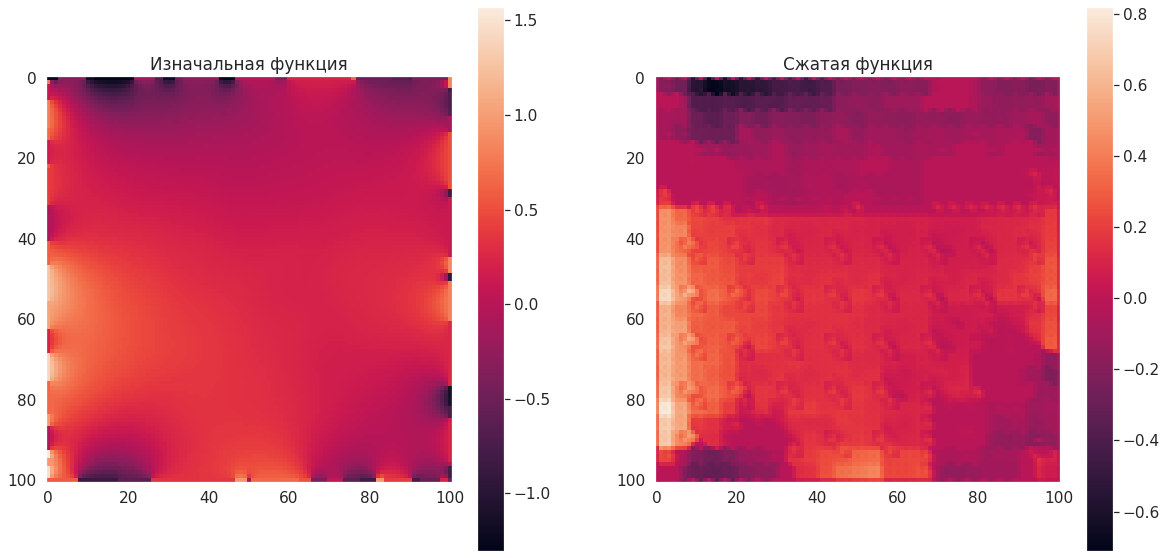

In [0]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
im = plt.imshow(test.reshape(N + 1, N + 1))
plt.colorbar(im)
plt.grid(False)
plt.title('Изначальная функция')

plt.subplot(1, 2, 2)
im = plt.imshow(result.reshape(N + 1, N + 1))
plt.colorbar(im)
plt.grid(False)
plt.title('Сжатая функция')
plt.show()

## То, что идет дальше, есть пример плохого подхода. На это не следует смотреть --- неверное использлование LSTM

In [0]:
def encode_x(batch):
    x = torch.from_numpy(batch).to(device=device, dtype=dtype)
    abs_x = torch.abs(x)
    batch_max_x = abs_x.max(axis=2).values.max(axis=1).values
    batch_max_x = batch_max_x.view(-1, 1, 1)
    x = x / batch_max_x
    batch_size = x.shape[0]
    N = x.shape[1] - 1
    x = x.view(batch_size, 1, N + 1, N + 1)
    x = model.encoder(x)
    return x, batch_max_x

def decode_x(x, batch_max_x):
    batch_size = x.shape[0]
    x = model.decoder(x)
    x = x.view(batch_size, N + 1, N + 1) * batch_max_x
    return x.cpu().detach().numpy().reshape(batch_size, N + 1, N + 1)

In [0]:
x_encoded, max_x = encode_x(test)
x_encoded = x_encoded.view(x_encoded.shape[0], -1)
x_encoded.transpose(1, 0).shape

torch.Size([480, 1])

In [0]:
class LSTM_step(nn.Module):

    def __init__(self):
        super(LSTM_step, self).__init__()
        self.lstm = nn.LSTM(480, 480)

    def forward(self, x):
        x = x.transpose(1, 0)
        x, (hn, cn) = self.lstm(x)
        return x.transpose(1, 0)

In [0]:
loader = DatasetGenerator(-1).load(
    dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data",
    load_history=True
)

In [0]:
train_data = next(loader)['history']

In [0]:
learning_rate = 1e-1
num_epochs = 20

In [0]:
lstm_model = LSTM_step()
lstm_model = lstm_model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [0]:
batch_size = 50
for epoch in range(num_epochs):
    mean_loss = 0
    for t in tqdm(range(0, train_data.shape[0], batch_size)):
        batch = train_data[t:t + batch_size]
        batch = batch.reshape(-1, 101, 101)
        batch_encoded, max_x = encode_x(batch)
        batch_encoded = batch_encoded.reshape(batch_size, 100, -1)
        output = lstm_model(batch_encoded)
        loss = criterion(output[:-5], batch_encoded[5:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss += loss.item()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, mean_loss / 20))


epoch [1/20], loss:4.6763



epoch [2/20], loss:1.3312



epoch [3/20], loss:0.5128



epoch [4/20], loss:0.1882



epoch [5/20], loss:0.0633



epoch [6/20], loss:0.0186



epoch [7/20], loss:0.0047



epoch [8/20], loss:0.0012



epoch [9/20], loss:0.0005



epoch [10/20], loss:0.0004



epoch [11/20], loss:0.0004



epoch [12/20], loss:0.0004



epoch [13/20], loss:0.0004



epoch [14/20], loss:0.0004



epoch [15/20], loss:0.0004



epoch [16/20], loss:0.0004



epoch [17/20], loss:0.0004



epoch [18/20], loss:0.0004



epoch [19/20], loss:0.0004



epoch [20/20], loss:0.0004


Посмотрим, как работает lstm:

In [0]:
test = next(dg.load(
    dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data/test",
    load_history=True
))['history']

test.shape

(1, 100, 101, 101)

In [0]:
test = test.reshape(-1, 101, 101)[:10]
test.shape

(10, 101, 101)

In [0]:
ouput = model(
    torch.from_numpy(test).view(-1, 1, 101, 101).to(device=device, dtype=dtype)
)
output.shape

RuntimeError: ignored

In [0]:
test_encoded, max_x = encode_x(test)
test_encoded = test_encoded.reshape(1, 100, -1)
begin_test_encoded = test_encoded[:, :10, :]
begin_max_x = max_x[:10]
output = lstm_model(begin_test_encoded)
output = output.view(-1, 30, 4, 4)
result = decode_x(output, begin_max_x)
approx_test = decode_x(begin_test_encoded.view(-1, 30, 4, 4),
                       begin_max_x)

Входные данные: 


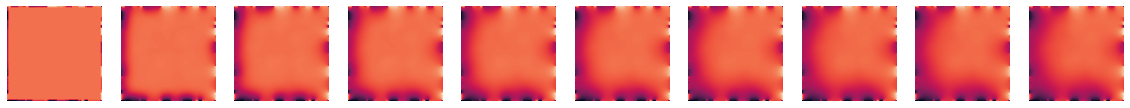

Аппроскимированные данные: 


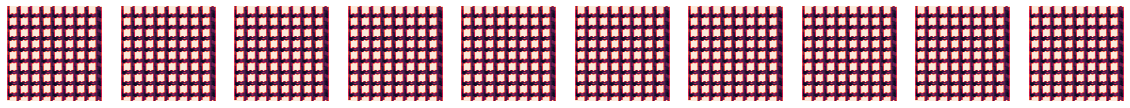

In [0]:
print('Входные данные: ')
plt.figure(figsize=(20, 4))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test[i])
    plt.axis('Off')
plt.show()

print('Аппроскимированные данные: ')
plt.figure(figsize=(20, 4))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(approx_test[i])
    plt.axis('Off')
    plt.grid("Off")
plt.show()